# Auto-Sklearn Hands-On


Great to have you here ♥

This notebook is part of the **Auto-sklearn Hands-On Session** for the [Next Gen AI workshop: Episode 3](https://freiburg-ai.github.io/). To edit this notebook, please copy it to your Google drive (`File` ➡ `Save a Copy in Drive`). You may find it easier to navigate this notebook by knowing the shortcuts `Ctrl + ]` to collapse all and `Ctrl + [` to expand all sections.

Here, you will learn to do the following:

  1. How to apply auto-sklearn to a dataset
  2. How to inspect the results after running auto-sklearn
  3. How to modify and edit auto-sklearn to yield more efficient/explainable/robust outcomes

For each task, we first describe the 📓**what** and ❓**why** of the tasks and the expected ✅**outcome** followed by some code you need to modify.

For this, this notebook is divided in the following sections:

  1. [Setup](#setup)
  2. [Task 1: Build your own pipeline](#task1)
  3. [Task 2: Run Auto-Sklearn](#task2)
  4. [Task 3: Explainability](#task3)

  Following these tasks, feel free to choose any of the following tasks which suit your interest!
  
  5. [Task 4: Custom Metrics](#task4)
  6. [Task 5: Multi-objective Optimization with Auto-Sklearn](#task5)
  7. [Task 6: AutoSklearn 2.0](#task6)
  8. [Task 7: Extending Auto-Sklearn](#task7)

You won't need to complete all of these, take your time.

For more details on the method or implementation, we refer you to our [publications](https://www.automl.org/automl/auto-sklearn/), our blogposts on [automl.org](https://www.automl.org/automl-blog/) and *of course*, the documentation on [GitHub](https://automl.github.io/auto-sklearn/master/) ✨

Auto-sklearn is drop-in replacement for any scikit-learn estimator and this is how it works:

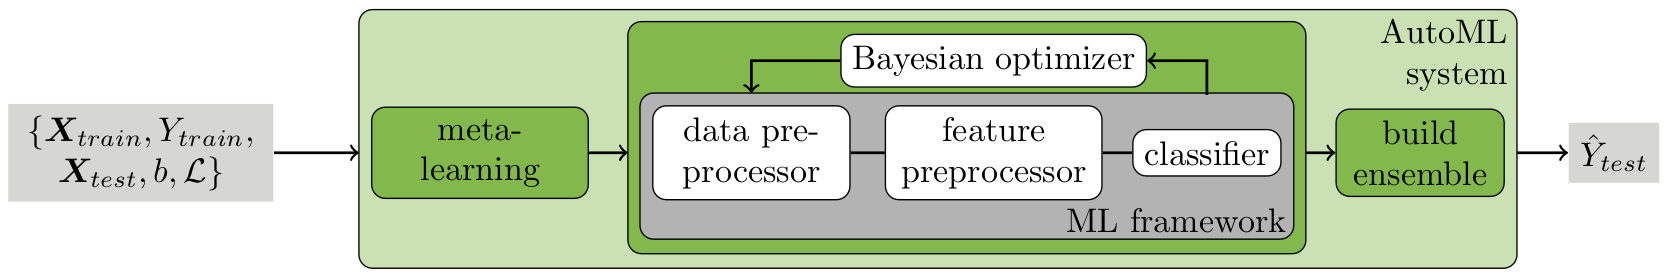


It is based on state-of-the-art AutoML technology and the well-known [scikit-learn](https://scikit-learn.org/stable/) library to provide **hands-free machine learning**.

<a name="setup"></a>
# 1. Setup

### 1a) Install Auto-sklearn

In order to run this code, we are going to first install Auto-sklearn using pip. For more instructions on how to install Auto-sklearn, for example using conda, please check [this](https://automl.github.io/auto-sklearn/master/installation.html).

**IMPORTANT: After installing all dependencies you need to restart the COLAB runtime (`Runtime` -> `Restart Runtime`) to have access to the newly installed packages!**

**NOTE: Installation will take ~5mins. This is the perfect opportunity to introduce yourself to your team and tell them what you're working on!**

In [ ]:
!pip uninstall --yes nvidia-ml-py3 pandas-profiling scipy
!pip install pandas-profiling auto-sklearn==0.15.0 shap
!pip install -U numpy==1.23.5
print("Done! Please restart the Notebook (Runtime -> Restart Runtime)")

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 82.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 96.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 99.9 MB/s eta 0:00:00
 

❗**Reminder: Restart the notebook before proceeding**

### 1b) Load Data and Define a Scoring Function

We will use the [credit-g](https://www.openml.org/d/31) dataset throughout this session. This datasets is a **binary classification task** and classifies credit requests into `good` or `bad` based on attributes, e.g. `amount`, `credit history` and `purpose of the credit`. We score a model based on the area under the [ROC curve](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

For this, we download the data, immediately split off the test set and define a scoring function.

In [1]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

# From OpenML: https://www.openml.org/d/31
dataset_name = "credit-g"

def get_data_and_scoring_function(dataset_name):  
    X, y = sklearn.datasets.fetch_openml(dataset_name, as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X,
        y,
        random_state=0,
        stratify=y,
    )

    def scoring_function(estimator):        
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)

    def train_scoring_function(estimator):        
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)

    def get_test_data():
        return X_test, y_test

    return X_train, y_train, get_test_data, scoring_function, train_scoring_function

X_train, y_train, get_test_data, scoring_function, train_scoring_function = get_data_and_scoring_function(dataset_name)

print(f"Done Processing and downloading {dataset_name}")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:404: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn("Multiple active versions of the dataset matching the name"


Done Processing and downloading credit-g


### 1c) Setup Pandas

In [2]:
import pandas as pd
pd.set_option('display.width', 120)

### 1d) Visualize Data (Optional) 

In [3]:
complete_df = pd.concat([y_train, X_train], axis=1)

In [4]:
complete_df.describe(include='all')

,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
count,750,750,750.000000,750,750,750.000000,750,750,750.000000,750,...,750.000000,750,750.000000,750,750,750.000000,750,750.000000,750,750
unique,2,4,NaN,5,10,NaN,5,5,NaN,4,...,NaN,4,NaN,3,3,NaN,4,NaN,2,2
top,good,no checking,NaN,existing paid,radio/tv,NaN,<100,1<=X<4,NaN,male single,...,NaN,car,NaN,none,own,NaN,skilled,NaN,none,yes
freq,525,297,NaN,400,210,NaN,448,260,NaN,412,...,NaN,246,NaN,618,538,NaN,478,NaN,448,724
mean,NaN,NaN,20.925333,NaN,NaN,3254.833333,NaN,NaN,2.961333,NaN,...,2.852000,NaN,35.369333,NaN,NaN,1.408000,NaN,1.141333,NaN,NaN
std,NaN,NaN,11.998989,NaN,NaN,2785.950633,NaN,NaN,1.122580,NaN,...,1.098957,NaN,11.352861,NaN,NaN,0.574435,NaN,0.348598,NaN,NaN
min,NaN,NaN,4.000000,NaN,NaN,276.000000,NaN,NaN,1.000000,NaN,...,1.000000,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
25%,NaN,NaN,12.000000,NaN,NaN,1367.500000,NaN,NaN,2.000000,NaN,...,2.000000,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
50%,NaN,NaN,18.000000,NaN,NaN,2288.000000,NaN,NaN,3.000000,NaN,...,3.000000,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
75%,NaN,NaN,24.000000,NaN,NaN,3963.500000,NaN,NaN,4.000000,NaN,...,4.000000,NaN,41.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN


In [5]:
import pandas_profiling
report = pandas_profiling.ProfileReport(complete_df, title="Pandas Profiling Report")
report

<ipython-input-5-dfc7740518b6>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<a name="task1"></a>
# Task 1: Build your own pipeline (BYOP; 15 minutes)

❓ **Why:** Even if you use AutoML methods, you should still take some time to understand the data and the pipeline you're going to use.

📓 **What:** Build your own scikit-learn pipeline

  1. Pre-process categorical and continuous features (if necessary)
  2. Choose a model type and train a predictive model
  3. Compute the score for your model
  4. Discuss the questions below 🔽 with your team members

If you are not familiar with scikit-learn you can find further information in the [docs](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators).

✅ **Outcome:** Questions to be discussed:

  1. Which model class have you used?
  2. What was your score?

In [6]:
# We'll start by checking out the effect of a OneHotEncoder
# First let's check out the distinct values of the "housing" and "own_telephone" columns
columns = ["housing", "own_telephone"] 
X_train[columns]

,housing,own_telephone
732,own,none
398,rent,none
933,own,yes
72,for free,yes
340,for free,yes
...,...,...
634,own,yes
19,own,yes
172,own,yes
739,rent,none


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Now lets see the effect of one hot encoding these columns and how that turns the
# distinct categoricals to numerical values we can feed to a machine learning pipeline
OHE = OneHotEncoder(handle_unknown='ignore')
raw_encoded_data = OHE.fit_transform(X_train[columns]).toarray()

# The OneHotEncoder will generate a new feature column per categoriy
# Let's see what these look like now that they're encoded
# This following line grabs the new encoded colun
encoded_columns = pd.DataFrame(
    raw_encoded_data,
    columns=OHE.get_feature_names(columns),
    dtype=int
)
encoded_columns

,housing_for free,housing_own,housing_rent,own_telephone_none,own_telephone_yes
0,0,1,0,1,0
1,0,0,1,1,0
2,0,1,0,0,1
3,1,0,0,0,1
4,1,0,0,0,1
...,...,...,...,...,...
745,0,1,0,0,1
746,0,1,0,0,1
747,0,1,0,0,1
748,0,0,1,1,0


In [8]:
# We'll now setup an sklearn pipeline that performs this OneHotEncoding
# to *all* the categorical columns and pass the numericals directly through to
# a model

# Import estimator and preprocessors you need
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Initialize your estimator
# Check the scikit-learn API for a complete list of classifier:
# https://scikit-learn.org/stable/supervised_learning.html
#------------------------- edit code here
estimator = DummyClassifier()


# Select the categorical columns to pass through our OneHotEncoder
categorical_selector = selector(dtype_include="category")
categorical_columns = categorical_selector(X_train)
print("Categorical Columns: ", categorical_columns)

# Select the numerical columns to 
numerical_selector = selector(dtype_exclude="category")
numerical_columns = numerical_selector(X_train)
print("Numerical Columns: ", numerical_columns)

# Build the ColumnTransformer which applies transformations to subsets of columns
# Feel free to include your own preprocessors
# https://scikit-learn.org/stable/modules/compose.html#column-transformer
preprocessor = ColumnTransformer(
    [
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('age', StandardScaler(), selector("age")),   
    ],
    remainder="passthrough"
)

# Assemble the pipeline with the preprocessor and the classifier
pipeline_byop = Pipeline([
  ('preprocessor', preprocessor),
  ('gradboost', estimator),
])
#-------------------------

pipeline_byop.fit(X_train, y_train)

# Show the prediction on the first 10 test instances
X_test, y_test = get_test_data()
predictions = pipeline_byop.predict(X_test) 

for prediction, actual_label in zip(predictions[:10], y_test[:10]):
   print(f"Predicted - {prediction:4} | actual - {actual_label}")

# Score the pipeline
performance_byop = train_scoring_function(pipeline_byop)
print(f"Train performance of my pipeline is {performance_byop}")

performance_byop = scoring_function(pipeline_byop)
print(f"Test performance of my pipeline is {performance_byop}")

Categorical Columns:  ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numerical Columns:  ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Predicted - good | actual - bad
Predicted - good | actual - bad
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Predicted - good | actual - good
Train performance of my pipeline is 0.5
Test performance of my pipeline is 0.5


<a name="task2"></a>
# Task 2: Auto-sklearn

❓ **Why:** You just manually built a predictive pipeline that works (pretty well). However this is for one specific dataset and with a very small _search space_ of what was tried.

Now you're ready to use Auto-sklearn. Can we automate **even more**?

📓 **What:** Run Auto-sklearn on a dataset, credit-g
  1. Run Auto-sklearn. Make sure that everyone at your table runs Auto-sklearn with a different setting, e.g. `resampling_strategy`, `ensemble_size`, `metric`,  (for more see [here](https://automl.github.io/auto-sklearn/master/api.html)).
     * While it's running, discuss how **you** would try automate the procedure from the previous exercise?
  2. Inspect the output
  3. Discuss the questions below 🔽 with your team members

✅ **Outcome:** While AutoML systems seemingly magically produce predictions, it is always a good to also understand how they work. Here are a few questions your boss, your client or your professor might ask you regarding using Auto-sklearn:

  * What pipelines were found? Was it better than your manual pipeline?
  * How pipelines did Auto-sklearn try?
  * AutoSklearn uses ensembling, what was the difference between the best model and the ensemble? How would you combine the different predictions of different piplines?
  * How did the different settings impact the result/statistics?
  * How would you search for different pipelines, how does AutoSklearn do it?
 
➕ **A Few Notes On Debugging**

Not everything works at the first try. Here are a few recommendations for [debugging](http://www.phdcomics.com/comics/archive/phd011406s.gif): 

  * Check the statistics: `estimator_askl.sprint_statistics()`
  * Check the evaluated models: `estimator_askl.show_models()`
  * Check the logs: Click the 📁 icon on the left, navigate to `/tmp/` and open the relevant Auto-sklearn logs in one of the `autosklearn_tmp_*` folders)
  * If nothing helps, try restarting the runtime and notebook
  * Do a factory reset as a last resort

#### Task 2a: Fitting Auto-sklearn

In [9]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc

In [10]:
# Edit the settings to try in both AutoSklearn
# Possibilities https://automl.github.io/auto-sklearn/master/api.html
#------------------------- edit code here
settings = {
  "time_left_for_this_task": 300, # Seconds
  "seed": 0,                      # The random seed to use
  "metric": roc_auc,              # What metric to optimize for
  "n_jobs": 4,                    # How many processes to use
  "ensemble_size": 10,            # How many models to put together for predictions 
  "resampling_strategy": "cv" # How to sample data internally for fitting models, "holdout" does a simple train-test splt, "cv" does cross-validation
}

Auto-sklearn follows the scikit-learn API to specify how to run in parallel by providing the argument `n_jobs`. If `n_jobs >= 1` the respective number of cores is used, for `n_jobs is None` 1 core is used and for `n_jobs < 0` all available cores are used. If you set `n_jobs != 1`, run Auto-sklearn on your local machine and have [Bokeh](https://bokeh.org/) installed, you also get access to the [Dask dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) which shows how the individual training jobs of Auto-sklearn are executed in a distributed fashion.

Lets train AutoSklearn with these settings

In [11]:
# Create and train an ensemble with AutoML 
# Auto-sklearn will take your data and automate your previous manual exploration
# This may take a while if you left the time at 300 seconds. This is a good time to:
#
# * Talk about how you would try automate this process
# * Checkout what arguments you can put in for settings: https://automl.github.io/auto-sklearn/master/api.html
#
askl = AutoSklearnClassifier(**settings)
askl.fit(X_train, y_train, dataset_name="credit-g")

<ipython-input-11-aae74dd77a04>:8: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 10}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
  askl = AutoSklearnClassifier(**settings)
/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 10}, ensemble_size=10,
                      metric=roc_auc, n_jobs=4, per_run_time_limit=120,
                      resampling_strategy='cv', seed=0,
                      time_left_for_this_task=300)

Now lets take a look at the summary statistics!

In [12]:
from pprint import pprint

print(f"Auto-sklearn | train = {train_scoring_function(askl)} | test = {scoring_function(askl)}")
print(f"Settings = {settings}")

# Some quick summary statistics
print("\nSummary")
print(askl.sprint_statistics())

# The leaderboard shows all the models during the optimization process,
# see this link for arguments if you want to see more!
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier.leaderboard
leaderboard = askl.leaderboard(
    sort_by="cost",
    ensemble_only=True,
    detailed=True
)

roc_auc_scores = 1 - leaderboard["cost"]
leaderboard.insert(loc=0, column=roc_auc.name, value=roc_auc_scores)
leaderboard

Auto-sklearn | train = 0.9977396825396826 | test = 0.838704761904762
Settings = {'time_left_for_this_task': 300, 'seed': 0, 'metric': roc_auc, 'n_jobs': 4, 'ensemble_size': 10, 'resampling_strategy': 'cv'}

Summary
auto-sklearn results:
  Dataset name: credit-g
  Metric: roc_auc
  Best validation score: 0.782603
  Number of target algorithm runs: 26
  Number of successful target algorithm runs: 20
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 5
  Number of target algorithms that exceeded the memory limit: 0



,roc_auc,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,,
2,0.782603,1,0.3,random_forest,0.217397,49.252535,1,2.220446e-17,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
13,0.772487,2,0.2,passive_aggressive,0.227513,26.233535,12,1.796481e-01,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[nystroem_sampler],weighting,Initial design
11,0.765757,3,0.1,qda,0.234243,16.515948,10,1.545079e-01,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
17,0.751386,4,0.1,sgd,0.248614,16.167601,16,1.688545e-01,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
14,0.747683,5,0.1,gradient_boosting,0.252317,61.136100,13,5.291005e-06,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[select_rates_classification],none,Initial design
10,0.739259,6,0.1,random_forest,0.260741,51.563062,9,1.190476e-04,0,1.686072e+09,1.686072e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],none,Initial design
24,0.707090,7,0.1,libsvm_svc,0.292910,17.825833,23,1.208862e-01,0,1.686072e+09,1.686073e+09,0.0,StatusType.SUCCESS,[],[feature_agglomeration],none,Initial design


In [13]:
# Show all the models in the final produced ensemble
pprint(askl.show_models())

{2: {'cost': 0.21739682539682542,
     'ensemble_weight': 0.3,
     'estimators': [{'balancing': Balancing(random_state=0),
                     'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7faf1d8956f0>,
                     'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7faf26a38100>,
                     'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7faf1d8961a0>,
                     'sklearn_classifier': RandomForestClassifier(max_features=7, n_estimators=512, n_jobs=1,
                       random_state=0, warm_start=True)},
                    {'balancing': Balancing(random_state=0),
                     'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7faf26ab5090>,
                     'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.Da

<a name="Task3"></a>
# Task 3: Explainability

❓ **Why:** To understand what features are important for producing a prediction.

📓 **What:** Apply feature importance methods to Auto-Sklearn. Auto-sklearn behaves like a scikit-learn estimator and thus any method that works with an scikit-learn estimator also works with Auto-sklearn. The [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) module offers some interesting features importance methods you can evaluate, and in this task you will use the permutation importance.

✅ **Outcome:** Discuss the questions below 🔽 with your team members


* Which features are important?
* Is anything striking about either of the plots?
* Can Auto-sklearn's design space be restricted to provide only interpretable models?
* What other feature importance methods could be applied (blackbox or whitebox)?

In [14]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import numpy as np

**Note**: In order to compute meaningful explanations we need data that is distinct from the training data, in this case we re-purpose the test set. This will take roughly two minutes if you've used `resampling_strategy='cv'` and much less if you've used `resampling_strategy='holdout'`. If you have time, you can increase the number of repetitions to get more reliable feature importance scores. If applicable, you can also move from cross-validation to holdout to improve speed here.

While the code runs, you could for example [read up how feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) works.

In [15]:
def get_data_for_feature_importance():
    # From OpenML: https://www.openml.org/d/31
    X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
    _, X_test, _, y_test = sklearn.model_selection.train_test_split(
      X, y, random_state=42
    )
    return X_test, y_test

X_feature_importance, y_feature_importance,  = get_data_for_feature_importance()

r = permutation_importance(
    askl, X_feature_importance, y_feature_importance,
    n_repeats=2, random_state=0, n_jobs=-1,
    scoring='roc_auc',
)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:404: UserWarning: Multiple active versions of the dataset matching the name credit-g exist. Versions may be fundamentally different, returning version 1.
  warn("Multiple active versions of the dataset matching the name"


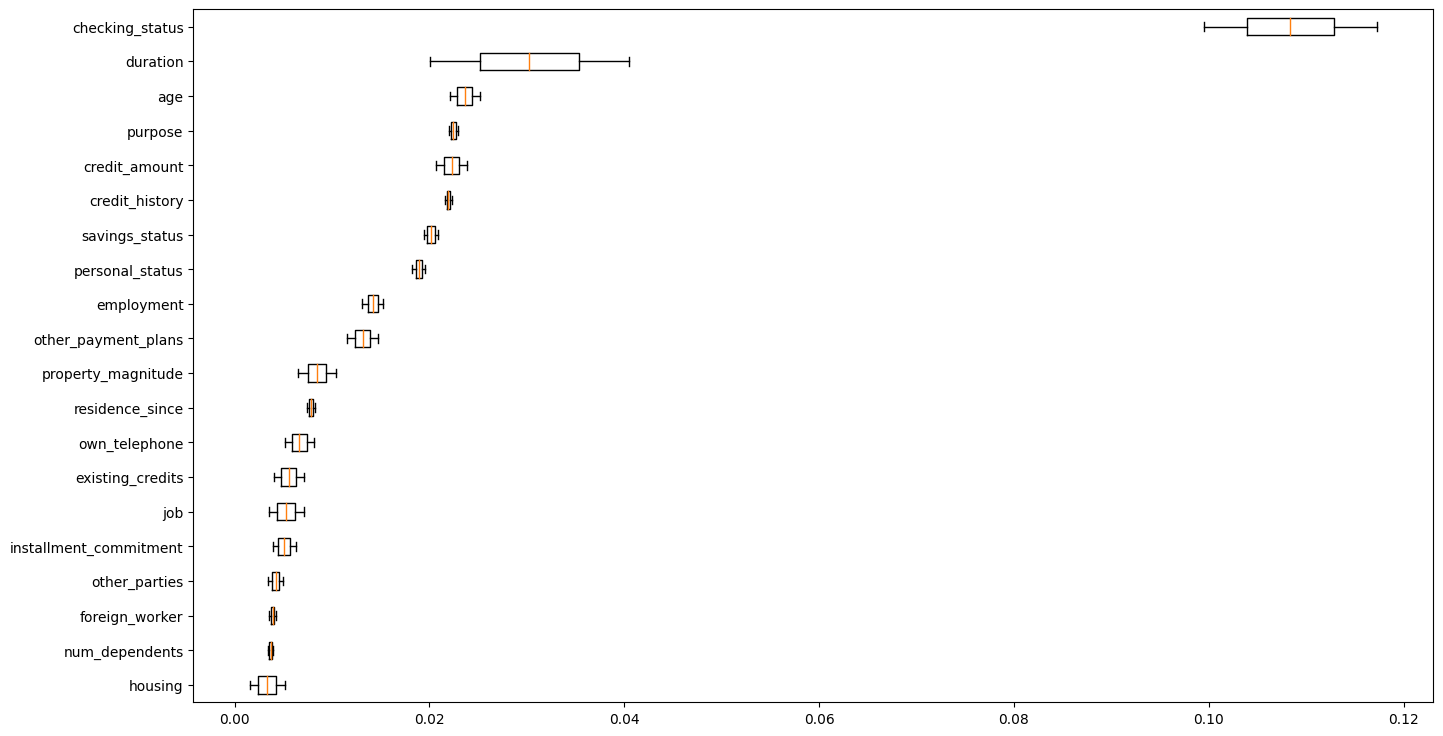

In [16]:
%matplotlib inline
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_train.columns[i] for i in sort_idx], vert=False)
fig.show()
plt.show()

[PD plots](https://christophm.github.io/interpretable-ml-book/pdp.html) describe the relation between feature values and the response value, i.e. the expected response value wrt. one or multiple input features. Since we use a classification dataset, this corresponds to the predicted class probability.

Unfortunatly this only works for numerical features and so we use the 2 numerical features which were considered the most important for classification.

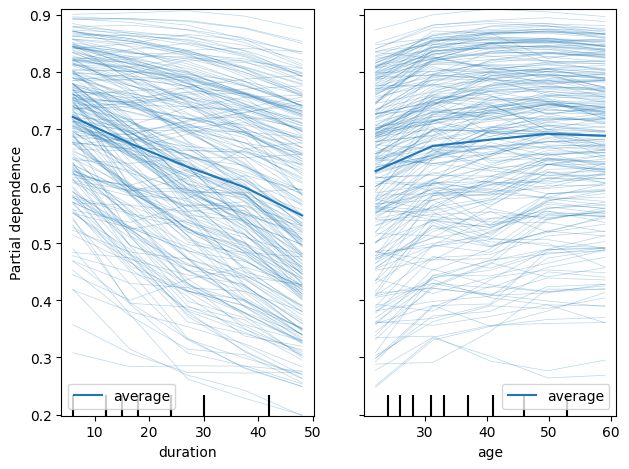

In [34]:
from sklearn.inspection import plot_partial_dependence

features = ["duration", "age"]

plot_partial_dependence(
    askl,
    X_test,
    features=features,
    grid_resolution=5,
    kind="both",
    feature_names=X_test.columns,
)
plt.tight_layout()
plt.show()

##### Other explainers

* Can use anything that works with sklearn
* [SHAP](https://github.com/slundberg/shap) can only be used for datasets without categorical features and without missing values
* We have such examples in a [EuroPython tutorial notebook](https://github.com/automl/auto-sklearn-talks/blob/main/2021_07_28_EuroPython/Tutorial-Regression.ipynb) and the [Auto-sklearn examples](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_inspect_predictions.html)

<a name="task4"></a>
# Task 4: Custom Metrics

❓ **Why:** Your predictive pipeline works great and you can make predictions for new datasets. However, the [area under the curve of the receiver operating curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (`roc_auc`) is just one of many metrics you may want to consider, what if you wanted to optimize for something like `balanced_accuracy` or a custom metric that is specific to your domain? You are the expert of your domain and it's important to allow auto-sklearn to optimize for this.

📓 **What:** Run Auto-sklearn with a custom metric and learn to define your own.

  1. Define a custom metric, you could use any of the examples taken from [here](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_metrics.html) or define your own!
  2. Run auto-sklearn briefly with this metric and see how it performs.
  3. Discuss what metrics matter in your domain with your team-mates.
  4. Check out the other built in metrics to auto-sklearn

✅ **Outcome:** Optimizing for different metrics will impact the kinds of models that perform well.

  * What's the final test performance for your metric?
  * Does Auto-sklearn handle the kinds of metrics you care about? [Check them out here](https://automl.github.io/auto-sklearn/master/api.html#built-in-metrics).
  * You may have got a warning such as `Could not find meta-data directory .../accu_binary.classification_dense`. This means we could not warm start optimization, why do you think this could be?

In [19]:
import numpy as np

from autosklearn.metrics import make_scorer
from autosklearn.classification import AutoSklearnClassifier

def custom_metric(solution, prediction):
    # custom function defining accuracy
    return np.mean(solution == prediction)


# Here we pass in the function as a custom metric to use, giving some meta information
# that autosklearn needs.
scorer = make_scorer(
    name="accu",
    score_func=custom_metric,
    optimum=1,
    greater_is_better=True,
    needs_proba=False,
    needs_threshold=False,
)

custom_metric_askl = AutoSklearnClassifier(
    time_left_for_this_task=60,
    seed=1,
    metric=scorer,
)

custom_metric_askl.fit(X_train, y_train, dataset_name='credit-g')
# Check out these example for more
# https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_metrics.html

/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2023-06-06 17:32:49,167:Client-AutoMLSMBO(1)::credit-g] Could not find meta-data directory /usr/local/lib/python3.10/dist-packages/autosklearn/metalearning/files/accu_binary.classification_dense


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      metric=accu, per_run_time_limit=6,
                      time_left_for_this_task=60)

In [20]:
leaderboard = custom_metric_askl.leaderboard()
leaderboard[scorer.name] = 1 - leaderboard["cost"]
leaderboard

,rank,ensemble_weight,type,cost,duration,accu
model_id,,,,,,
2,1,0.24,random_forest,0.245968,3.294198,0.754032
3,2,0.06,gradient_boosting,0.274194,2.803802,0.725806
7,3,0.08,gaussian_nb,0.286290,0.948304,0.713710
9,4,0.02,random_forest,0.290323,2.260608,0.709677
11,5,0.06,bernoulli_nb,0.298387,1.064797,0.701613
8,6,0.50,sgd,0.500000,1.104282,0.500000
5,7,0.04,gaussian_nb,0.653226,1.743554,0.346774


<a name="task5"></a>
# Task 5: Multi-objective Optimization with Auto-sklearn

❓ **Why:** Your predictive pipeline works great and you can make predictions for new datasets. However, the [area under the curve of the receiver operating curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (`roc_auc`) actually combines two separate measures. Wouldn't it be better to optimize for different tradeoffs between them and select a point afterwards?

📓 **What:** Run Auto-sklearn in a multi-objective setting on the credit-g dataset

  1. Run Auto-sklearn optimizing for [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) by passing two metrics to Auto-sklearn.
  2. Inspect the statistics, especially the leaderboard, to see how the two metrics interact with each other. You can also viasualize the trade-offs in a 2d plot.
  3. Discuss the questions below 🔽 with your team members
  4. Have a look at the [ParEGO](https://www.cs.bham.ac.uk/~jdk/parego/) algorithm that powers multi-objective optimization in Auto-sklearn

✅ **Outcome:** When optimizing for more than one objective, the questions of interest will change:

  * What's the final test performance for the different metrics?
  * How much would you lose when in precision when picking the solution with maximal recall, and vice versa?
  * How do the different models trade off precision and recall?
  * How does the model optimized for roc_auc trade off the two objectives?
  * Could you automatically choose a model for deployment?

In [21]:
import numpy as np

from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import precision, recall

# Precision and recall require encoding the positive/minority class as 1
# and the negative/majority class as 0:
y_train_01 = np.array([1 if val == "bad" else 0 for val in y_train])

# Create and train an ensemble with AutoML 
moo_askl = AutoSklearnClassifier(
    #------------------------- edit code here
    time_left_for_this_task=120, # in seconds
    seed=1, 
    resampling_strategy='holdout',
    # https://automl.github.io/auto-sklearn/master/api.html#built-in-metrics
    metric=[precision, recall],
    n_jobs=4,
    delete_tmp_folder_after_terminate=False,
    #-------------------------
)
# Auto-sklearn ingests the pandas dataframe and detects column types
moo_askl.fit(X_train, y_train_01, dataset_name='credit-g')

AutoSklearnClassifier(delete_tmp_folder_after_terminate=False,
                      ensemble_class=<class 'autosklearn.ensembles.multiobjective_dummy_ensemble.MultiObjectiveDummyEnsemble'>,
                      metric=[precision, recall], n_jobs=4,
                      per_run_time_limit=48, time_left_for_this_task=120)

In [22]:
print(moo_askl.leaderboard(ensemble_only=False))

          rank  ensemble_weight                type    cost_0    cost_1   duration
model_id                                                                          
2            7              0.0       random_forest  0.425532  0.635135  11.439021
3            3              0.0         extra_trees  0.375000  0.662162  10.919446
4           21              0.0         extra_trees  0.670000  0.554054  10.245620
5           10              0.0   gradient_boosting  0.513158  0.500000  10.537572
6           12              0.0                 mlp  0.537313  0.581081  21.277855
7            1              1.0       random_forest  0.350000  0.648649   9.206698
8           18              0.0  passive_aggressive  0.639344  0.702703   5.872123
9            2              0.0       random_forest  0.360000  0.783784  11.522079
10          14              0.0       random_forest  0.542857  0.351351   9.483218
11          17              0.0          libsvm_svc  0.638095  0.486486  31.848933
12  

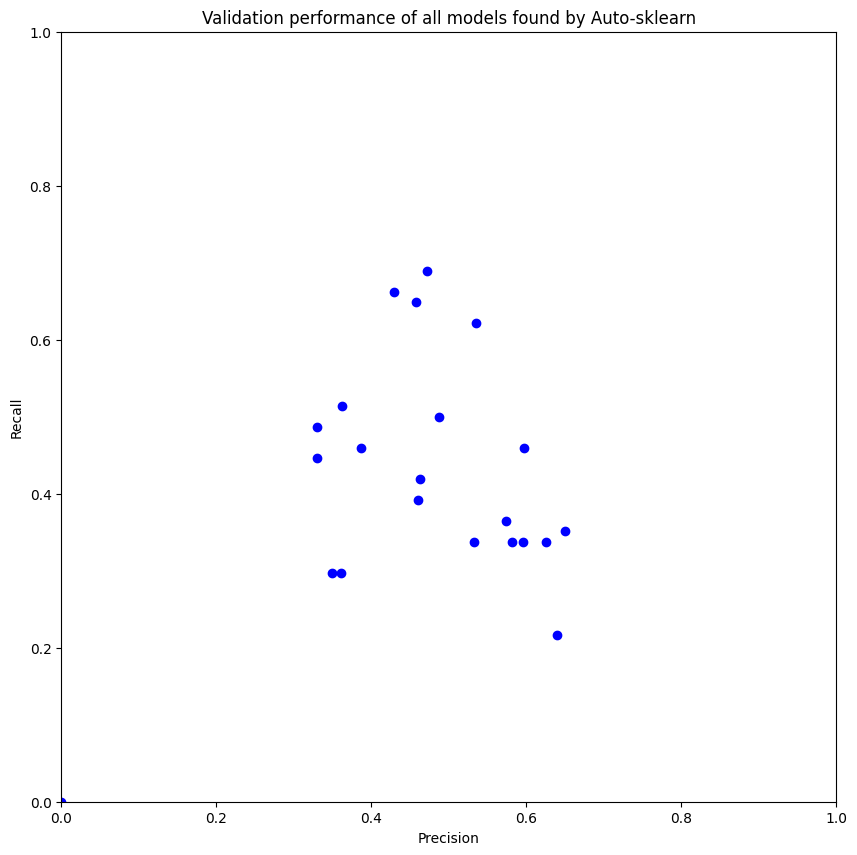

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

lb = moo_askl.leaderboard(ensemble_only=False)
for neg_precision, neg_recall in zip(lb["cost_0"], lb["cost_1"]):
    ax.scatter(1 - neg_precision, 1 - neg_recall, color="blue")

_ = ax.set_xlabel("Precision")
_ = ax.set_ylabel("Recall")
_ = ax.set_xlim((0, 1))
_ = ax.set_ylim((0, 1))
_ = ax.set_title("Validation performance of all models found by Auto-sklearn")

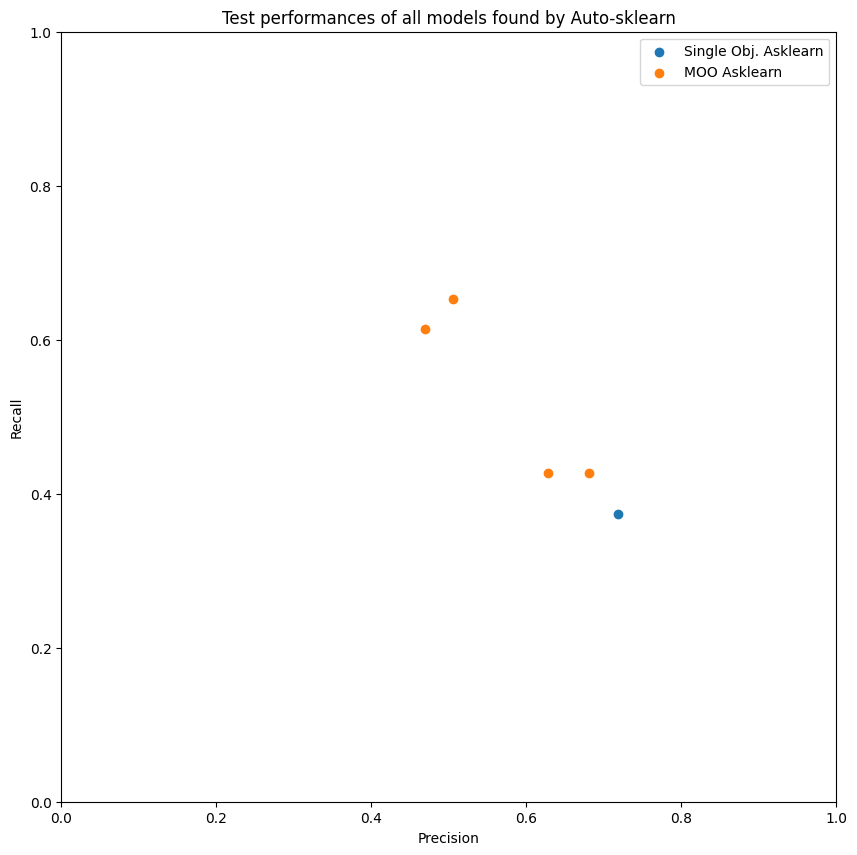

In [24]:
# 1st, create a new figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# 2nd, get the test data
X_test, y_test = get_test_data()
y_test_01 = np.array([1 if val == "bad" else 0 for val in y_test])

# 3rd predict on the test data using the single-objective Auto-sklearn & plot perf

single_objective_predictions = askl.predict(X_test)
single_objective_predictions = np.array([1 if val == "bad" else 0 for val in single_objective_predictions])
single_objective_precision = sklearn.metrics.precision_score(y_test_01, single_objective_predictions)
single_objective_recall = sklearn.metrics.recall_score(y_test_01, single_objective_predictions)

ax.scatter(single_objective_precision, single_objective_recall, label="Single Obj. Asklearn")

# 4th iterate all entries in the [Pareto front approximation](https://en.wikipedia.org/wiki/Pareto_front) 
# of the multi-objective Auto-sklearn optimization and plot them
to_plot = {"precision": [], "recall": []}
for ensemble in moo_askl.get_pareto_set():
    predictions = ensemble.predict(X_test)
    to_plot["precision"].append(sklearn.metrics.precision_score(y_test_01, predictions))
    to_plot["recall"].append(sklearn.metrics.recall_score(y_test_01, predictions))

ax.scatter(to_plot["precision"], to_plot["recall"], label="MOO Asklearn")

# 5th Label the plot
_ = ax.set_xlabel("Precision")
_ = ax.set_ylabel("Recall")
_ = ax.set_xlim((0, 1))
_ = ax.set_ylim((0, 1))
_ = ax.legend()
_ = ax.set_title("Test performances of all the pareto set models found by Auto-sklearn")

<a name="task6"></a>
# Task 6: AutoSklearn 2.0

❓ **Why**: Selecting a good validation strategy is crucial to not overfit to the data at hand, specifically with smaller datasets. However choosing the right validation strategy is a hard task. Why not automate this? AutoSklearn 2.0 does this with meta-learning!

📓 **What**:

* Run Auto-sklearn and Auto-Sklearn 2.0 on a dataset, credit-g
* Inspect the statistics between the two versions.
* Discuss the questions below 🔽 with your team members, you can do so while the two are running

✅ **Outcome**:

* When would you apply crossvalidation, holdout and/or successive halving?
* How many function evaluations were performed for Auto-Sklearn versus Auto-Sklearn 2.0?
* How did the results change between the two versions?
* What resampling-strategy's did you consider, did AutoSklearn 2.0 agree?
* How does the final ensemble differ from the ensemble constructed by Auto-sklearn 1.0? Bigger/smaller, models, hyperparameters?

In [25]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc

# Edit the settings to try in both AutoSklearn1 and AutoSklearn2
# Possibilities https://automl.github.io/auto-sklearn/master/api.html

#------------------------- edit code here
settings = {
  "time_left_for_this_task": 120,  # seconds
  "seed": 42,
  "metric": roc_auc,
  "n_jobs": 4,
}

# This will only be used by autosklearn 1 while autosklearn 2 will automatically
# select a strategy
resampling_strategy = "holdout"

In [26]:
# Create and train AutoSklearn 1
askl1 = AutoSklearnClassifier(
    **settings,
    resampling_strategy=resampling_strategy
)
askl1.fit(X_train, y_train, dataset_name="credit-g")

/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      metric=roc_auc, n_jobs=4, per_run_time_limit=48, seed=42,
                      time_left_for_this_task=120)

In [27]:
# Create and train AutoSklearn2.0 
askl2 = AutoSklearn2Classifier(**settings)
askl2.fit(X_train, y_train, dataset_name="credit_g")

/usr/local/lib/python3.10/dist-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():
/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


AutoSklearn2Classifier(metric=roc_auc, n_jobs=4, per_run_time_limit=48, seed=42,
                       time_left_for_this_task=120)

Now let's compare them!



In [28]:
from pprint import pprint

print(f"Auto-sklearn 1.0 | train = {train_scoring_function(askl1)} | test = {scoring_function(askl1)}")
print(f"Selected `resampling-strategy` = {askl1.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl1.resampling_strategy_arguments}")

# Some quick summary statistics
print(askl1.sprint_statistics())

# Show all the models in the final produced ensemble
# pprint(askl1.show_models())

# For compatibility with scikit-learn we implement `cv_results_`, but the output is pretty lengthy, so we leave this commented
# print(askl1.cv_results_)

# The leaderboard shows all the models during the optimization process,
# see this link for arguments if you want to see more!
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier.leaderboard
askl1.leaderboard(sort_by="model_id", ensemble_only=True)

Auto-sklearn 1.0 | train = 0.9291851851851852 | test = 0.8131047619047619
Selected `resampling-strategy` = holdout
Selected `resampling-strategy-arguments` = None
auto-sklearn results:
  Dataset name: credit-g
  Metric: roc_auc
  Best validation score: 0.771746
  Number of target algorithm runs: 25
  Number of successful target algorithm runs: 23
  Number of crashed target algorithm runs: 1
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



,rank,ensemble_weight,type,cost,duration
model_id,,,,,
4,5,0.02,extra_trees,0.252912,12.569929
8,9,0.02,mlp,0.277804,20.207448
11,1,0.54,qda,0.228254,3.784497
12,2,0.06,gradient_boosting,0.242311,24.065662
13,3,0.04,passive_aggressive,0.249146,5.065065
14,10,0.08,gradient_boosting,0.283201,9.888026
17,4,0.04,sgd,0.249884,6.826406
19,8,0.02,gradient_boosting,0.264368,34.290656
20,7,0.08,random_forest,0.257029,9.593854


In [29]:
print(f"Auto-sklearn 2.0 | train = {train_scoring_function(askl2)} | test = {scoring_function(askl2)}")
print(f"Selected `resampling-strategy` = {askl2.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl2.resampling_strategy_arguments}")

print(askl2.sprint_statistics())

# pprint(askl2.show_models())
# print(askl2.cv_results_)

askl2.leaderboard(sort_by="model_id", ensemble_only=True)

Auto-sklearn 2.0 | train = 0.9727492063492064 | test = 0.8246857142857142
Selected `resampling-strategy` = cv-iterative-fit
Selected `resampling-strategy-arguments` = {'folds': 3}
auto-sklearn results:
  Dataset name: credit_g
  Metric: roc_auc
  Best validation score: 0.756216
  Number of target algorithm runs: 19
  Number of successful target algorithm runs: 18
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 1
  Number of target algorithms that exceeded the memory limit: 0



,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,2,0.02,gradient_boosting,0.257702,17.999379
8,1,0.06,gradient_boosting,0.243784,22.487028
9,4,0.04,mlp,0.263492,20.750345
10,5,0.02,mlp,0.317841,33.333862
11,7,0.82,sgd,0.429803,32.122662
14,3,0.02,gradient_boosting,0.262451,20.430571
15,6,0.02,passive_aggressive,0.327289,20.963497


<a name="task7"></a>
# Task 7: Extending Auto-Sklearn

❓ **Why:** Learn how to adapt the Auto-sklearn design space and understand the consequences of doing so.

📓 **What:** Extend Auto-sklearn with your own parameterized model

  1. Implement the new component. Some ideas are
    1. Re-add a [scikit-learn model](https://scikit-learn.org/stable/supervised_learning.html) (for classification)
    2. [XGBoost](https://github.com/dmlc/xgboost)
    3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
  2. Run auto-sklearn (restricted to only your component)
  3. Study the statistics
  3. Discuss the questions below 🔽 with your team members


✅ **Outcome:** We will ask you the following: 

  1. What component did you add?
  2. What's the score you obtained?
  3. What do you think happens to the meta-learning part of Auto-sklearn, i.e. the set of configuration Auto-sklearn uses to warmstart?

In [30]:
# First implement your model. As a guideline, we provide a copy of: 
# https://github.com/automl/auto-sklearn/blob/master/autosklearn/pipeline/components/classification/adaboost.py
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, \
    UniformIntegerHyperparameter, CategoricalHyperparameter

from autosklearn.pipeline.components.base import AutoSklearnClassificationAlgorithm
from autosklearn.pipeline.constants import DENSE, UNSIGNED_DATA, PREDICTIONS, SPARSE

class MyNewModel(AutoSklearnClassificationAlgorithm):
    def __init__(self, n_estimators, learning_rate, algorithm, max_depth,
                random_state=None):
        # All hyperparameters are args
        #------------------------- edit code here
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.algorithm = algorithm
        self.random_state = random_state
        self.max_depth = max_depth
        self.estimator = None
        #-------------------------


    def fit(self, X, Y, sample_weight=None):
        # Fit the model
        #------------------------- edit code here
        import sklearn.ensemble
        import sklearn.tree

        self.n_estimators = int(self.n_estimators)
        self.learning_rate = float(self.learning_rate)
        self.max_depth = int(self.max_depth)
        base_estimator = sklearn.tree.DecisionTreeClassifier(max_depth=self.max_depth)

        estimator = sklearn.ensemble.AdaBoostClassifier(
            base_estimator=base_estimator,
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            algorithm=self.algorithm,
            random_state=self.random_state
        )

        estimator.fit(X, Y, sample_weight=sample_weight)
        #-------------------------
        self.estimator = estimator
        return self

    def predict(self, X):
        if self.estimator is None:
            raise NotImplementedError
        return self.estimator.predict(X)

    def predict_proba(self, X):
        if self.estimator is None:
            raise NotImplementedError()
        return self.estimator.predict_proba(X)

    @staticmethod
    def get_properties(dataset_properties=None):
        #------------------------- edit code here (optional)
        return {'shortname': 'MAB',
                'name': 'My AdaBoost Classifier',
                'handles_regression': False,
                'handles_classification': True,
                'handles_multiclass': True,
                'handles_multilabel': False,
                'handles_multioutput': False,
                'is_deterministic': True,
                'input': (DENSE, SPARSE, UNSIGNED_DATA),
                'output': (PREDICTIONS,)}
        #-------------------------

    @staticmethod
    def get_hyperparameter_search_space(feat_type=None, dataset_properties=None):
        #------------------------- edit code here
        # https://automl.github.io/ConfigSpace/main/api/hyperparameters.html#advanced-types
        cs = ConfigurationSpace()

        n_estimators = UniformIntegerHyperparameter(
            name="n_estimators", lower=50, upper=500, default_value=50, log=False)
        learning_rate = UniformFloatHyperparameter(
            name="learning_rate", lower=0.01, upper=2, default_value=0.1, log=True)
        algorithm = CategoricalHyperparameter(
            name="algorithm", choices=["SAMME.R", "SAMME"], default_value="SAMME.R")
        max_depth = UniformIntegerHyperparameter(
            name="max_depth", lower=1, upper=10, default_value=1, log=False)

        cs.add_hyperparameters([n_estimators, learning_rate, algorithm, max_depth])
        #-------------------------
        return cs

In [31]:
from autosklearn.pipeline.components.classification import ClassifierChoice, add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc

# Now you can add your component
add_classifier(MyNewModel)

for name in ClassifierChoice.get_components():
    # this should also print the name of your model
    print(name)
  
# Create and train an ensemble with AutoML 
estimator_askl_mod = AutoSklearnClassifier(
    time_left_for_this_task=30,
    seed=42, 
    resampling_strategy='holdout',
    metric=roc_auc,
    # It is possible to run Auto-sklearn in parallel with additional components 
    # if these components are in separate modules and the components are 
    # imported when using auto-sklearn
    n_jobs=1,
    # above is same as before, but here we restrict the design space to your new model
    include={
        'classifier': [
            'MyNewModel',
        ]
    },
)
# Auto-sklearn ingests the pandas dataframe and detects column types
estimator_askl_mod.fit(X_train, y_train, dataset_name='credit-g')

adaboost
bernoulli_nb
decision_tree
extra_trees
gaussian_nb
gradient_boosting
k_nearest_neighbors
lda
liblinear_svc
libsvm_svc
mlp
multinomial_nb
passive_aggressive
qda
random_forest
sgd
MyNewModel


/usr/local/lib/python3.10/dist-packages/autosklearn/data/target_validator.py:187: UserWarning: Fitting transformer with a pandas series which has the dtype category. Inverse transform may not be able preserve dtype when converting to np.ndarray
  warnings.warn(


[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 630 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 6 not found
[WARNING] [2023-06-06 17:39:47,144:Client-AutoMLSMBO(42)::credit-g] Configuration 22 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 702 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 161 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 489 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 467 not found
[WARNING] [2023-06-06 17:39:47,143:Client-AutoMLSMBO(42)::credit-g] Configuration 91 not found
[WARNING] [2023-06-06 17:39:47,144:Client-AutoMLSMBO(42)::credit-g] Configuration 601 not found
[WARNING] [2023-06-06 17:39:47,144:Client-AutoMLSMBO(42)::credit-g] Configuration 221 not found
[WARNING] [2023-06-06 17:39:47,144:Client-Au

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      include={'classifier': ['MyNewModel']}, metric=roc_auc,
                      n_jobs=1, per_run_time_limit=3, seed=42,
                      time_left_for_this_task=30)

In [32]:
performance_askl = train_scoring_function(estimator_askl_mod)
print(f"Train Auto-Sklearn Classifier performance is {performance_askl}")
performance_askl = scoring_function(estimator_askl_mod)
print(f"Test Auto-Sklearn Classifier performance is {performance_askl}")

Train Auto-Sklearn Classifier performance is 0.9310814814814815
Test Auto-Sklearn Classifier performance is 0.7636571428571429
